# GMM : Gaussian Mixture Model

A Gaussian Mixture Model is a combination of Gaussian models with different parameters. For instance, this is the PDF of a GMM made with two Gaussian Models:   

$$
Y \sim \frac{1}{3} \mathcal{N}(\mu_1, \Sigma_1) + \frac{2}{3} \mathcal{N}(\mu_2, \Sigma_2)
$$

For each point simulated by such a model, we first choose the Gaussian distribution (1 or 2), then simulate using the law of the chosen Gaussian.

For example, let's simulate this law once: we start by drawing 1 with proba 1/3 or 2 with proba 2/3. If 1 is drawn, we then run the $\mathcal{N}(\mu_1, \Sigma_1)$ law. If 2 is drawn, we run the $\mathcal{N}(\mu_2, \Sigma_2)$ law.

Let's simulate this law:


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [20]:
# GMM parameters

m = [
    np.array([0, 0]),
    np.array([0, 0])
]

Q = np.array([[-1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)]])
D1 = np.array([[10, 0], [0, 1]])
D2 = np.array([[1, 0], [0, 10]])

cov = [
    Q @ D1 @ Q.T,
    Q @ D2 @ Q.T
]

w = [1/3, 2/3]

indices = np.random.choice(2, size=1000,p=w)
print(indices)

[0 1 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 0 1 1 0 1
 1 1 1 0 1 0 1 0 1 0 0 0 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 0
 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1
 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 1 1 1 0 1
 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0
 0 0 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 0
 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1
 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 0
 1 1 1 0 0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 1
 0 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0 0 0
 1 1 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 0 0 1
 1 0 1 1 1 1 1 1 0 0 0 0 

Below, the first Gaussian (proba 1/3) is simulated in blue, and the second Gaussian (proba 2/3) in red.

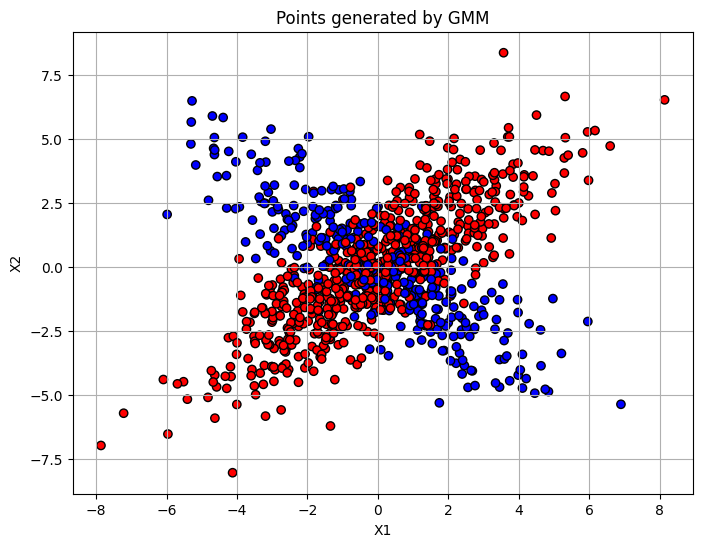

In [18]:
data = np.zeros((1000, 2))
colors = np.zeros(1000, dtype=str)
for k, (mk, covk) in enumerate(zip(m, cov)):
    data[indices == k] = np.random.multivariate_normal(mk, covk, np.sum(indices == k))
    colors[indices == k] = 'blue' if k == 0 else 'red'

plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=colors, marker='o', edgecolor='k')
plt.title('Points generated by GMM')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show()

# GMM modeling and EM algo

In reality, we have a scatterplot and would like to model it by a GMM. Modeling” by a GMM means finding the parameters of the two Gaussians, but also the coefficients in front of them (just with the scatterplot below, who can say that the distribution is 1/3 2/3? it's not obvious):

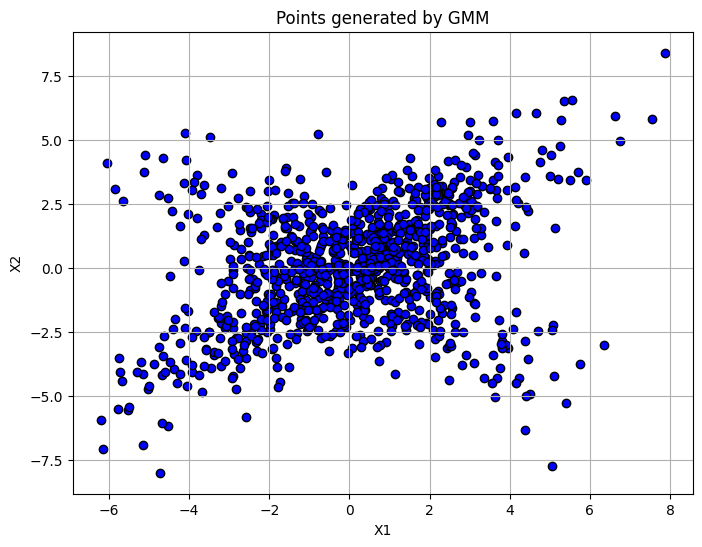

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c="blue", marker='o', edgecolor='k')
plt.title('Points generated by GMM')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show()

At the center, it seems impossible to know which Gaussian each point belongs to. So there are **11 parameters** to find out: $\mu_1$ (2 parameters), $\Sigma_1$ (matrix of 3 parameters), $\mu_2$ (2 parameters), $\Sigma_2$ (matrix of 3 parameters), and $w_1$ the proba weight of the first gaussian.

Note: $\Sigma_1$ has only 3 parameters (and not 4) because it is symmetric. $w_2$ is not a parameter because $w_2=1-w_1$.

All we know is that we model the point cloud by the following PDF:

$$ Y \sim w_{1} \mathcal{N}(\mu_1, \Sigma_1) + w_{2} \mathcal{N}(\mu_2, \Sigma_2) $$

With $w_1 + w_2 = 1$.

This is where the EM algorithm comes in. See the .pdf for theoretical explanations.

In [130]:
def e_step(data, mu_t, Sigma_t, w_t):
    gamma_t = np.zeros((1000,2))  # gamma_ij(t)
    for i in range(1000):  # this "1000" is the number of observations -> n=1000
      for j in range(2):   # this "2" is the number of classes -> J=2
          gamma_t[i, j] = w_t[j] * multivariate_normal.pdf(data[i,:], mean=mu_t[j,:], cov=Sigma_t[j,:,:])
      gamma_t[i,:]=gamma_t[i,:]/(gamma_t[i,:].sum())

    w_tp1 = gamma_t.sum(axis=0)/1000 # w_j(t+1)

    return gamma_t, w_tp1   # gamma_ij(t)  and w_j(t+1)


In [131]:
def m_step(data, gamma_t, w_tp1):
    mu_tp1 = gamma_t.T @ data / (1000*w_tp1[:, np.newaxis])  # "gamma_t.T @ data" is a multiplication of matrices (Jxn)x(nxm) = (Jxm) so we must use np.newaxis (technique called "broadcasting")
    Sigma_tp1 = np.zeros((2, 2, 2))   # the first 2 is J, the two other 2 are m (the dimension of the space)

    for j in range(2):
        diff = data - mu_tp1[j]
        Sigma_tp1[j,:,:] = np.dot(gamma_t[:, j] * diff.T, diff) / (1000*w_tp1[j])

    return mu_tp1, Sigma_tp1


In [154]:
def run_em(data, mu_t, Sigma_t, w_t, nb_iter=100,tol=1e-4):
    log_likelihoods = []

    for i in range(nb_iter):
        # E-step
        gamma_t,w_tp1 = e_step(data, mu_t, Sigma_t, w_t)

        # M-step
        mu_tp1, Sigma_tp1 = m_step(data, gamma_t, w_tp1)

        Q=0
        for i in range(1000):  # this "1000" is the number of observations -> n=1000
            for j in range(2):   # this "2" is the number of classes -> J=2
                Q += gamma_t[i, j] * np.log(w_t[j]*multivariate_normal.pdf(data[i,:], mean=mu_t[j,:], cov=Sigma_t[j,:,:]))
        log_likelihoods.append(Q)

        mu_t = mu_tp1
        Sigma_t = Sigma_tp1
        w_t = w_tp1

        if len(log_likelihoods) > 1 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return mu_tp1, Sigma_tp1, w_tp1, log_likelihoods


Final mu:
 [[-0.04838996  0.08125813]
 [-0.02779588 -0.06349731]]
Final Sigma:
 [[[ 5.44146076 -4.48974418]
  [-4.48974418  5.57272709]]

 [[ 5.33490897  4.48857188]
  [ 4.48857188  5.67267859]]]
Final weights:
 [0.34094361 0.65905639]


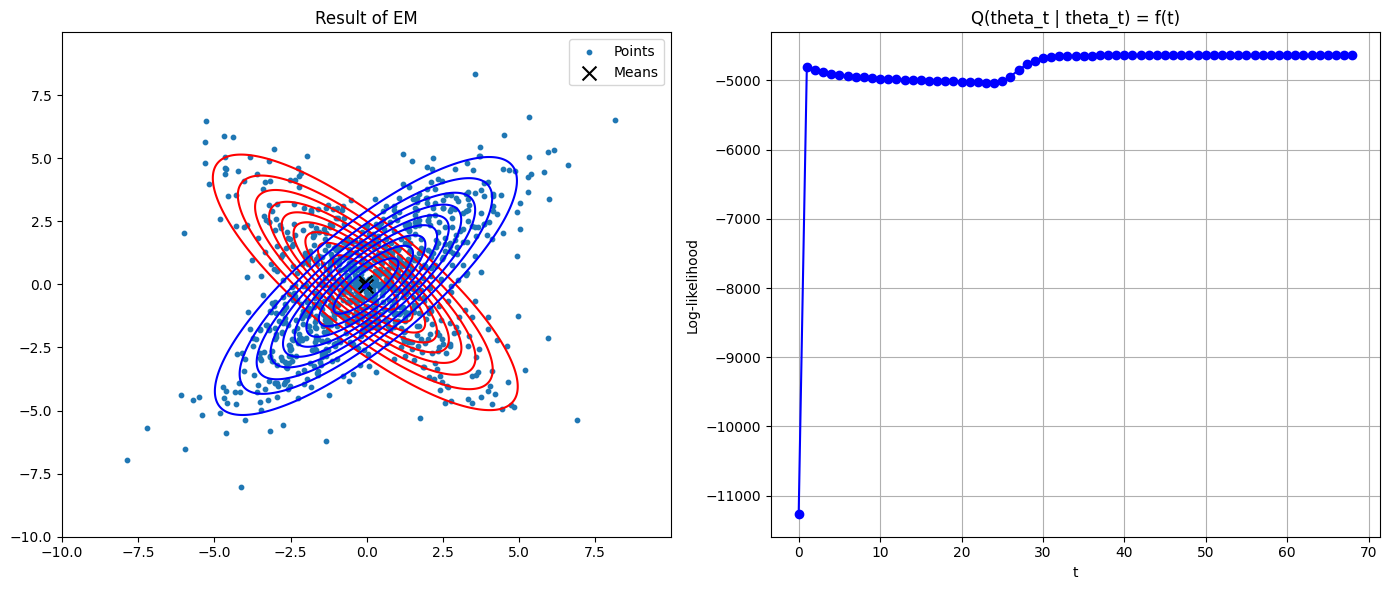

In [155]:
mu_t = np.array([[-5, 0], [5, 0]])
Sigma_t = np.array([np.eye(2), np.eye(2)])
w_t = np.array([0.5, 0.5])

mu_final, Sigma_final, pi_final, log_likelihoods = run_em(data, mu_t, Sigma_t, w_t)
print("Final mu:\n", mu_final)
print("Final Sigma:\n", Sigma_final)
print("Final weights:\n", pi_final)

def plot_results(data, mu, Sigma, ax):
    ax.scatter(data[:, 0], data[:, 1], s=10, label="Points")

    x, y = np.mgrid[-10:10:.01, -10:10:.01]
    pos = np.dstack((x, y))

    for k in range(2):
        rv = multivariate_normal(mu[k], Sigma[k])
        ax.contour(x, y, rv.pdf(pos), levels=10, colors='r' if k == 0 else 'b')

    ax.scatter(mu[:, 0], mu[:, 1], c='black', marker='x', s=100, label="Means")
    ax.set_title('Result of EM')
    ax.legend()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

plot_results(data, mu_final, Sigma_final, axs[0])

axs[1].plot(log_likelihoods, marker='o', linestyle='-', color='b')
axs[1].set_title('log_likelihood(x,theta_t)=Q(theta_t | theta_t) = f(t)')
axs[1].set_xlabel('t')
axs[1].set_ylabel('Log-likelihood')
axs[1].grid(True)

plt.tight_layout()
plt.show()

**Observation:** The EM algorithm achieves a remarkable result given the point of initialization, but the optimization process is laborious with almost 70 iterations and an evolution that seems very slow. What's more, we observe a quasi-decrease in log-likelihood in the first iterations, which is very strange as it runs counter to theory.

Let's try it with initial conditions much closer to the optimum (because we're lucky, we deliberately built the point cloud ourselves to know the optimum!).

Final mu:
 [[-0.02779588 -0.06349731]
 [-0.04838996  0.08125813]]
Final Sigma:
 [[[ 5.33490902  4.48857195]
  [ 4.48857195  5.67267865]]

 [[ 5.44146066 -4.48974405]
  [-4.48974405  5.57272698]]]
Final weights:
 [0.65905638 0.34094362]


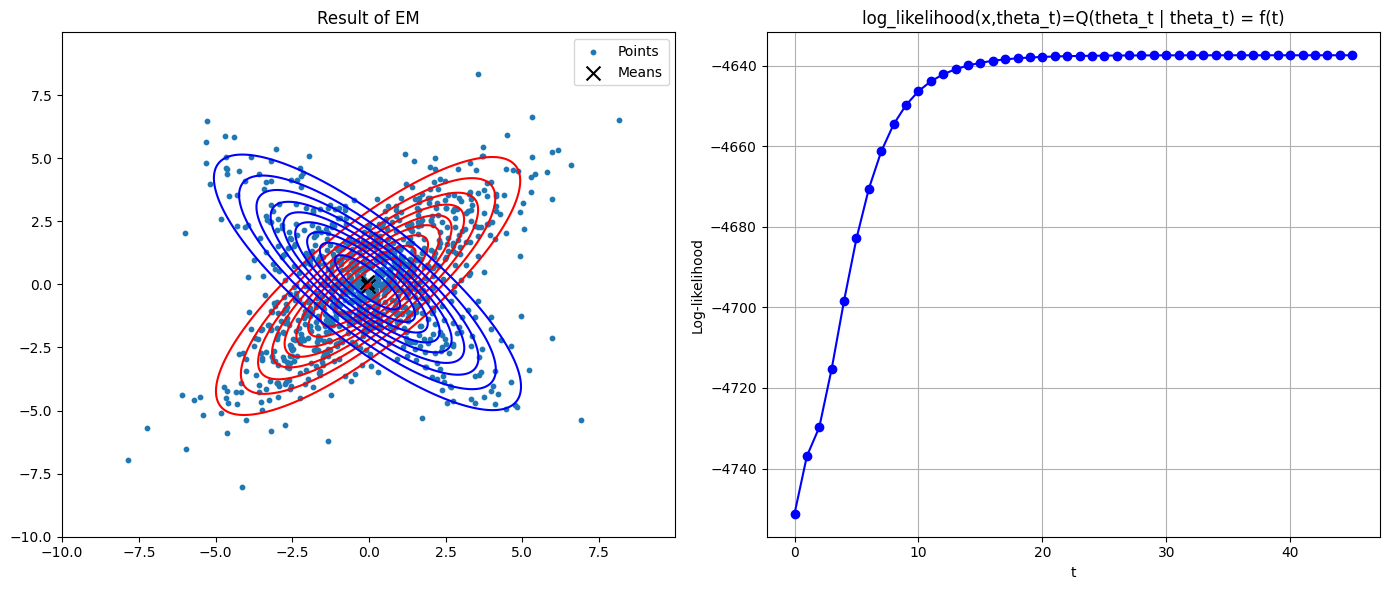

In [156]:
mu_t = np.array([[0, 0], [0, 0]])
Sigma_t = np.array([[[5,4.6],[4.6,5]], [[6,-4],[-4,6]]])
w_t = np.array([0.5, 0.5])

mu_final, Sigma_final, pi_final, log_likelihoods = run_em(data, mu_t, Sigma_t, w_t)
print("Final mu:\n", mu_final)
print("Final Sigma:\n", Sigma_final)
print("Final weights:\n", pi_final)

def plot_results(data, mu, Sigma, ax):
    ax.scatter(data[:, 0], data[:, 1], s=10, label="Points")

    x, y = np.mgrid[-10:10:.01, -10:10:.01]
    pos = np.dstack((x, y))

    for k in range(2):
        rv = multivariate_normal(mu[k], Sigma[k])
        ax.contour(x, y, rv.pdf(pos), levels=10, colors='r' if k == 0 else 'b')

    ax.scatter(mu[:, 0], mu[:, 1], c='black', marker='x', s=100, label="Means")
    ax.set_title('Result of EM')
    ax.legend()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

plot_results(data, mu_final, Sigma_final, axs[0])

axs[1].plot(log_likelihoods, marker='o', linestyle='-', color='b')
axs[1].set_title('log_likelihood(x,theta_t)=Q(theta_t | theta_t) = f(t)')
axs[1].set_xlabel('t')
axs[1].set_ylabel('Log-likelihood')
axs[1].grid(True)

plt.tight_layout()
plt.show()

**Observation:** Unsurprisingly, the EM algorithm converges faster (in just 45 iterations). The log-likelihood curve is increasing: in line with theory.

So far, we've been working on a point cloud that's not very kind to the algorithm, since the two Gaussians are superimposed. We're going to be kinder and see what happens if the two clouds aren't superimposed.

Final mu:
 [[-1.74408478  3.34835204]
 [ 5.01780629 -5.05172419]]
Final Sigma:
 [[[5.95781988 4.49717134]
  [4.49717134 5.32264636]]

 [[5.4165457  4.62493786]
  [4.62493786 5.8892658 ]]]
Final weights:
 [0.335 0.665]


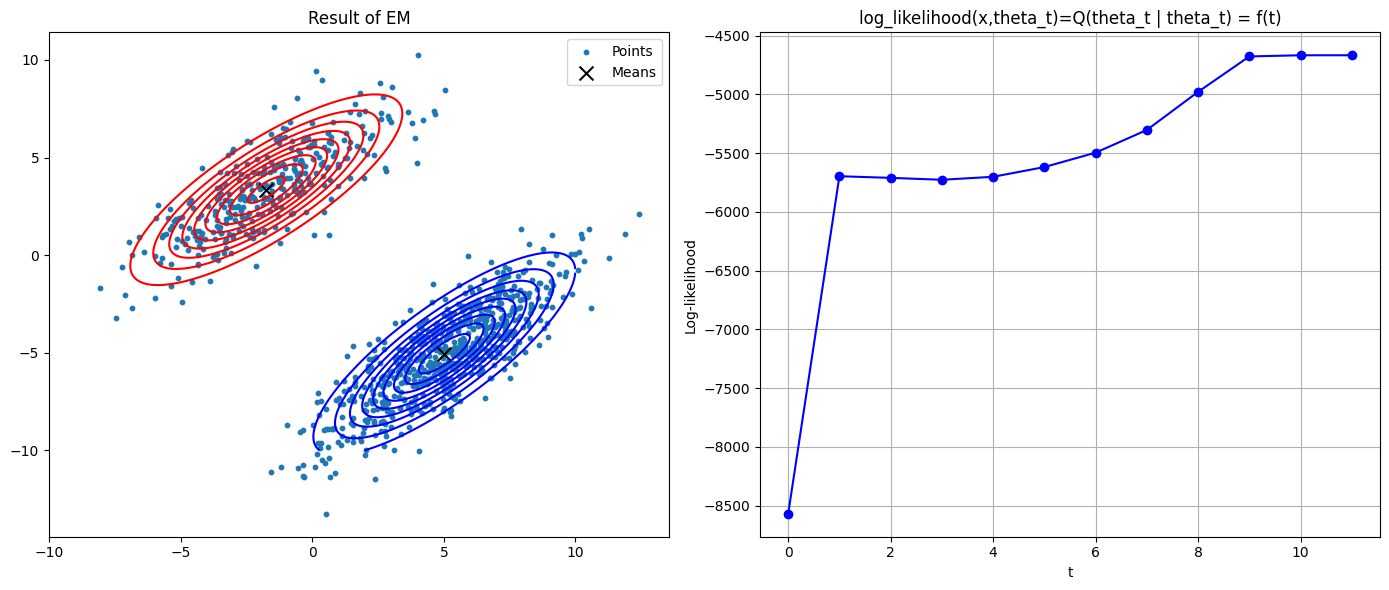

In [157]:
# GMM parameters

m = [
    np.array([-2, 3]),
    np.array([5, -5])
]

Q = np.array([[-1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)]])
D1 = np.array([[1, 0], [0, 10]])
D2 = np.array([[1, 0], [0, 10]])

cov = [
    Q @ D1 @ Q.T,
    Q @ D2 @ Q.T
]

w = [1/3, 2/3]

indices = np.random.choice(2, size=1000,p=w)

data2 = np.zeros((1000, 2))
colors = np.zeros(1000, dtype=str)
for k, (mk, covk) in enumerate(zip(m, cov)):
    data2[indices == k] = np.random.multivariate_normal(mk, covk, np.sum(indices == k))
    colors[indices == k] = 'blue' if k == 0 else 'red'

mu_t = np.array([[0, 0], [0, 0]])
Sigma_t = np.array([[[5,4.6],[4.6,5]], [[6,-4],[-4,6]]])
w_t = np.array([0.5, 0.5])

mu_final, Sigma_final, pi_final, log_likelihoods = run_em(data2, mu_t, Sigma_t, w_t)
print("Final mu:\n", mu_final)
print("Final Sigma:\n", Sigma_final)
print("Final weights:\n", pi_final)

def plot_results(data, mu, Sigma, ax):
    ax.scatter(data[:, 0], data[:, 1], s=10, label="Points")

    x, y = np.mgrid[-10:10:.01, -10:10:.01]
    pos = np.dstack((x, y))

    for k in range(2):
        rv = multivariate_normal(mu[k], Sigma[k])
        ax.contour(x, y, rv.pdf(pos), levels=10, colors='r' if k == 0 else 'b')

    ax.scatter(mu[:, 0], mu[:, 1], c='black', marker='x', s=100, label="Means")
    ax.set_title('Result of EM')
    ax.legend()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

plot_results(data2, mu_final, Sigma_final, axs[0])

axs[1].plot(log_likelihoods, marker='o', linestyle='-', color='b')
axs[1].set_title('log_likelihood(x,theta_t)=Q(theta_t | theta_t) = f(t)')
axs[1].set_xlabel('t')
axs[1].set_ylabel('Log-likelihood')
axs[1].grid(True)

plt.tight_layout()
plt.show()

**Observation:** Only 11 iterations to converge!

# Conclusion

The EM algorithm performs well even when two Gaussians are superimposed. Unsurprisingly, however, the algorithm is much more efficient when the Gaussians are clearly distinguishable (but this case is less funny).